# Autoencoder

In [ ]:
# Autoencoder는 정답이 없음 (비지도학습)
# 인코딩 - 디코딩
# 인코딩 : 정보 특징을 추출하여 압축함
# 디코딩 : 정보가 들어오면 원본데이터로 변환

# Autoencoder는 이상치 데이터를 감지할 수 있음
# DAE : Denoisging auto encoder 이미지를 복원할 수 있음
# 흑백 사진을 컬러 사진을 복원할 수 있음
# 사진에 필터를 쓴 이미지를 필터를 제거할 수 있음

In [ ]:
# 인코딩 - Bottleneck - 디코딩
# Bottleneck : 모든 데이터가 압축되어 있음 (차원을 축소함)

In [ ]:
# 이미지데이터 - 인코딩(Data가 가진 수십,수백개의 변수로부터 중요한 몇가지의 변수를 추출) - latent vector - 디코딩(다시 입력 data에 가까운 고차원 데이터로 복원)
# Autoencoder에는 입력도 x, 정답도 x
# 신경망은 범용근사자로서 근사치를 출력, x와 똑같은 출력을 내긴 힘듬
# 복원오차(정보손실값)(reconstruction loss) 사용
# Autoencoder는 입력과 출력의 크기는 같지만 중간으로 갈수록 신경망의 차원이 축소
# 작은차원으로 압축된 표현을 잠재변수,z 라고함
# 인코더는 정보를 받아 압축하고 디코더는 압축된 표현을 풀어 입력을 복원한다.


# Variational Autoencoder

In [ ]:
# 생성형 모델의 기본
# Encoding : Decoder에 어떤 입력 latent variable z를 넣을지 학습
# Decoding : 입력데이터와 유사한 새로운 데이터 생성
# VAE는 확률 분포함

# Autodencoder 실습

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms,datasets


# 시각화를 위해 3차원으로 줄임
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 색상값 뽑아오기 위해 cm
from matplotlib import cm
import numpy as np

In [ ]:
# mnist 데이터 28x28 - Encoder (차원을 줄여나감) - Lantent Space(3차원의 공간으로 밀어넣음) - Deconder(28x28개로 빠져나오게함)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainset = datasets.FashionMNIST(root='./',train=True,download=True,transform=transforms.ToTensor())

# 입력값만있으면 됌
# 입력값 외에 데이터가 들어오면 이상한 데이터라고 파악함
# testset = datasets.FashionMNIST(root='./',train=False,download=True,transform=transforms.ToTensor())

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)

In [ ]:
train_loader.batch_size

32

In [ ]:
# Autoencoder 모듈
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()

    # 데이터가 압축되는 부분
    self.encoder = nn.Sequential(

        # cnn 써도됌
        # 들어오는 이미지 사이즈,output
        nn.Linear((28*28),128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        # 마지막에는 3차원으로 축소 , 3이 Latent Space(vector)
        nn.Linear(12,3),
    )

    self.decoder = nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        # 마지막 시그모이드 : 마지막에 0~1사이값으로, 흑백이기 때문에
        nn.Sigmoid()

    )

  def forward(self,x):

    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    # encoded : 데이터 압축
    # decoded : 데이터 복원
    return encoded, decoded

In [ ]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
# 손실함수로 MSELoss() 사용, 복원 전과 후가 어떻게 다른지
criterion = nn.MSELoss()

In [ ]:
# 이미지가 어떻게 압축되는지 보기 위한 함수

def train(model,train_loader):
  # 훈련 모드
  model.train()

  for step,(data,label) in enumerate(train_loader):
    # input으로 1차원으로 펴줌
    x = data.view(-1,28*28).to(device)
    # x와 y를 비교할 것이기 때문에 x와 똑같은 y
    y = data.view(-1,28*28).to(device)

    # 출력용(확인용)
    label = label.to(device)

    encoded, decoded = model(x)

    # 복원된 값과 y 값 비교
    loss = criterion(decoded,y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

In [ ]:
view_data = trainset.data[:5]
view_data.shape

torch.Size([5, 28, 28])

In [ ]:
view_data = view_data.view(-1,28*28)
view_data.shape

torch.Size([5, 784])

In [ ]:
view_data = view_data.type(torch.FloatTensor)/255
view_data[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
        0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0039, 0.0039, 0.0000, 

In [ ]:
view_data.data, len(view_data.data) , view_data.data.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 5,
 torch.Size([5, 784]))

 epoch :  1


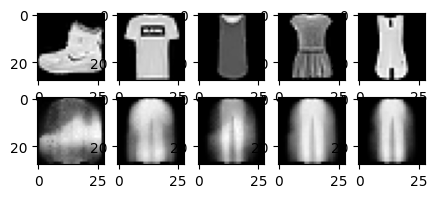

 epoch :  2


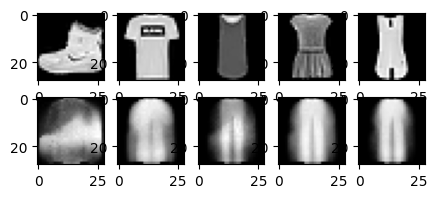

 epoch :  3


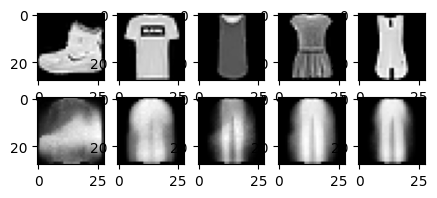

 epoch :  4


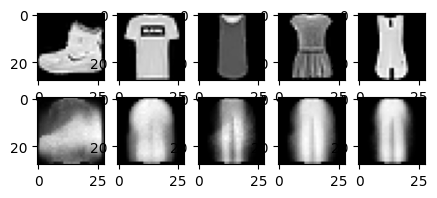

 epoch :  5


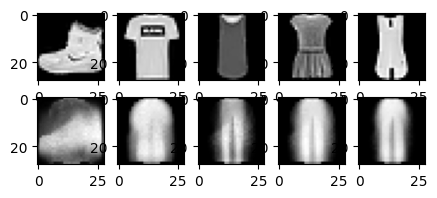

 epoch :  6


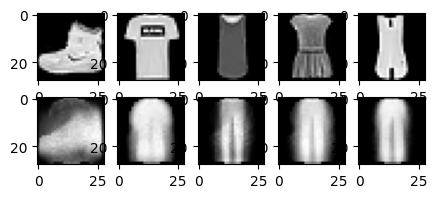

 epoch :  7


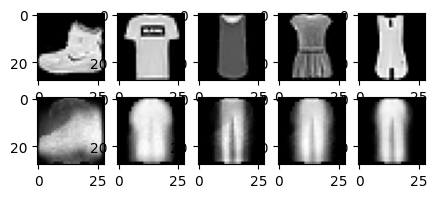

 epoch :  8


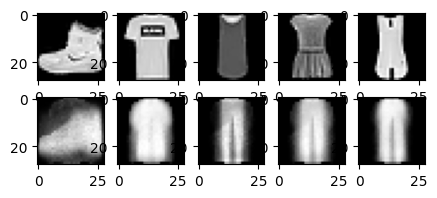

 epoch :  9


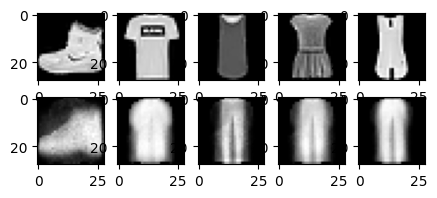

 epoch :  10


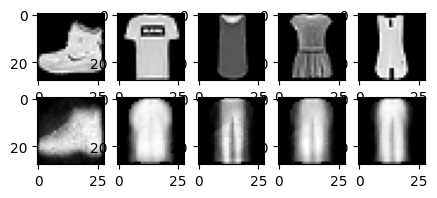

 epoch :  11


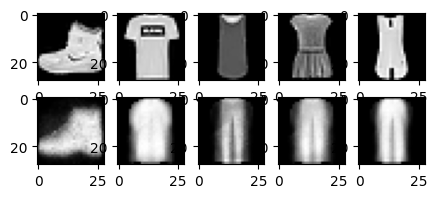

 epoch :  12


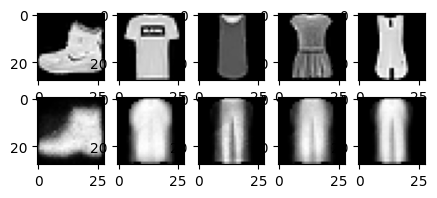

 epoch :  13


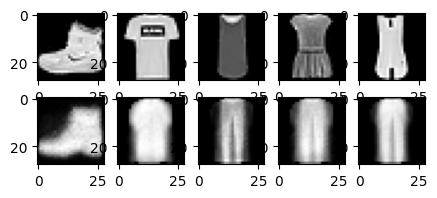

 epoch :  14


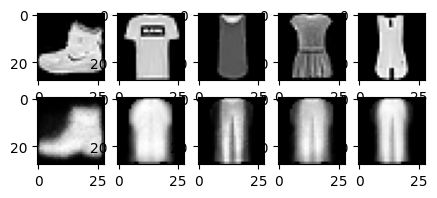

 epoch :  15


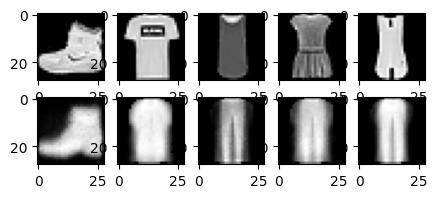

 epoch :  16


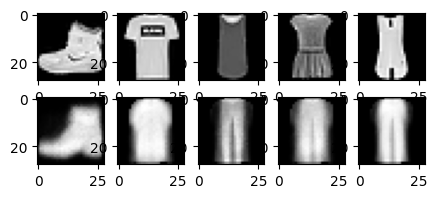

 epoch :  17


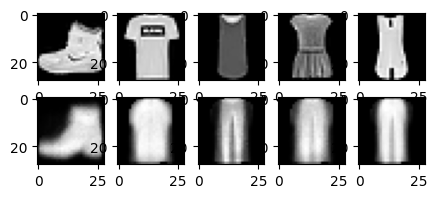

 epoch :  18


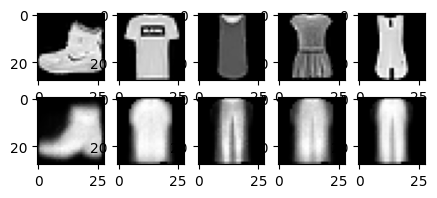

 epoch :  19


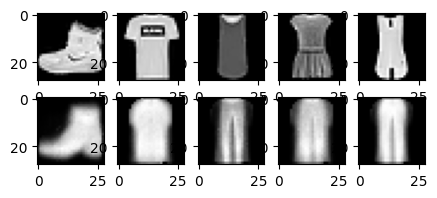

 epoch :  20


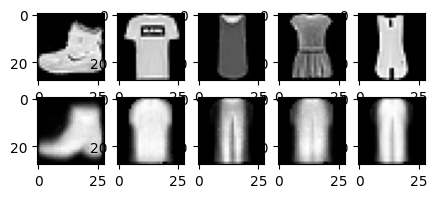

In [ ]:
for epoch in range(20):

  # 모델 학습
  train(model,train_loader)

  # 원본이미지
  test_x = view_data.to(device)

  # 원본 이미지 encoded,decoded
  _,decoded_data = model(test_x)

  f,a = plt.subplots(2,5,figsize=(5,2))

  print(" epoch : ",epoch+1)

  # 원본 이미지
  for i in range(5):
    img = np.reshape(view_data.data.numpy()[i],(28,28))
    a[0][i].imshow(img,cmap='gray')

  # decode 이미지
  for i in range(5):
    img = np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28))
    a[1][i].imshow(img,cmap='gray')

  plt.show()

### 이상치 데이터 encoder,decoder

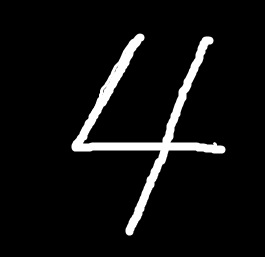

In [ ]:
from PIL import Image
img = Image.open('/content/4.jpg')
img

In [ ]:
# tensor로 바꾸기
img = transforms.ToTensor()(img)
# Resize
img = transforms.Resize(28)(img)
# grayscale로 바꾸기 (현재 이미지는 3채널)
img = transforms.Grayscale()(img)
img.shape

torch.Size([1, 28, 28])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 1, 28, 28])

In [ ]:
img = img.view(-1,28*28)
img.shape

torch.Size([1, 784])

In [ ]:
img = img.to(device)

In [ ]:
_,pred = model(img)
img = np.reshape(pred.to('cpu').data.numpy()[0],(28,28))
img.shape

(28, 28)

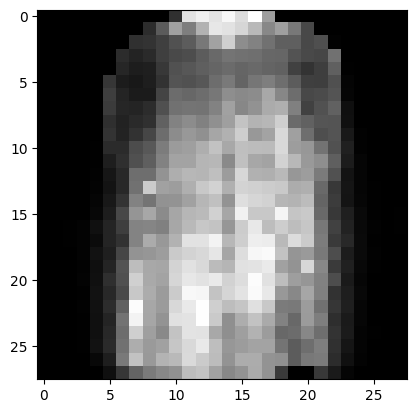

In [ ]:
plt.imshow(img,cmap='gray')

### 모델의 압축된 데이터 확인 (latent sapce를 3차원 그래프로 시각화)

In [ ]:
# 원본 이미지 200개 추출
view_data = trainset.data[:200]
view_data.shape

torch.Size([200, 28, 28])

In [ ]:
view_data = view_data.view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# gpu로
test_x = view_data.to(device)

# 모델에 데이터 200개를 넣음
encoded_data,_ = model(test_x)

encodede_data = encoded_data.to('cpu')

In [ ]:
test_x.size()

torch.Size([200, 784])

In [ ]:
# 압축됌
encoded_data.size()

torch.Size([200, 3])

In [ ]:
# 3차원으로 압축했음
encoded_data[0]

tensor([ 8.5864,  2.0573, -4.2041], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# 아무 숫자나 집어넣어도 decoder로 비슷한 그림이 나옴(생성 모델과 유사)

In [ ]:
data1 = torch.FloatTensor([1.234,-5.777,9.559])
data1

tensor([ 1.2340, -5.7770,  9.5590])

In [ ]:
data1.shape

torch.Size([3])

In [ ]:
data1 = data1.view(-1,3)
data1.shape

torch.Size([1, 3])

#### 아무 데이터나 넣어서 이미지 복원해보기

In [ ]:
from random import *

data2 = torch.FloatTensor([uniform(-10,10) for x in range(784)])
data2.shape

torch.Size([784])

In [ ]:
data2 = data2.view(-1,28*28)
data2.shape

torch.Size([1, 784])

In [ ]:
_,data2_decoded = model(data2.to(device))
data2_decoded

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4951e-03, 2.7426e-01,
         1.7411e-01, 1.1901e-01, 1.1847e-01, 1.3722e-01, 1.8308e-01, 1.3856e-01,
         1.5911e-28, 2.4179e-32, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7652e-31,
         3.1677e-04, 5.4343e-03, 5.3455e-02, 4.2171e-02, 6.4770e-02, 7.8222e-02,
         1.3802e-01, 5.2717e-02, 4.9666e-02, 5.5991e-02, 5.2213e-02, 9.0899e-03,
         1.9089e-04, 3.5338e-22, 1.1564e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.1667e-24, 1.3691e-04, 4.4289e-04, 1.3461e-03,
         9.7581e-03, 1.3075e-02, 1.9795e-02, 5.9915e-02, 6.1694e-02, 2.9942e-02,
         2.6424e-02, 1.7219e

In [ ]:
data2_decoded_img = np.reshape(data2_decoded.to('cpu').data.numpy()[0],(28,28))
data2_decoded_img.shape

(28, 28)

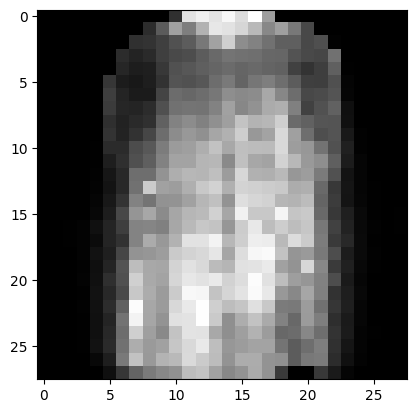

In [ ]:
plt.imshow(img,cmap='gray')

### 아무 데이터 생성해서 decoder만 사용하기

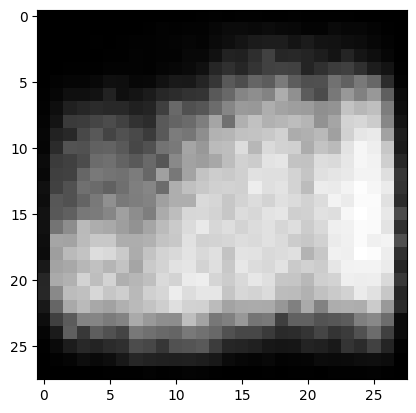

In [ ]:
# 랜덤으로 바지,신발을 만들 수 있음

img = model.decoder(torch.tensor([-4.2 , -4.1 , 8.2]).to(device))
plt.figure()
img = np.reshape(img.to('cpu').data.numpy(),(28,28))
plt.imshow(img,cmap='gray')

In [ ]:
from mpl_toolkits.mplot3d import axes3d

In [ ]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

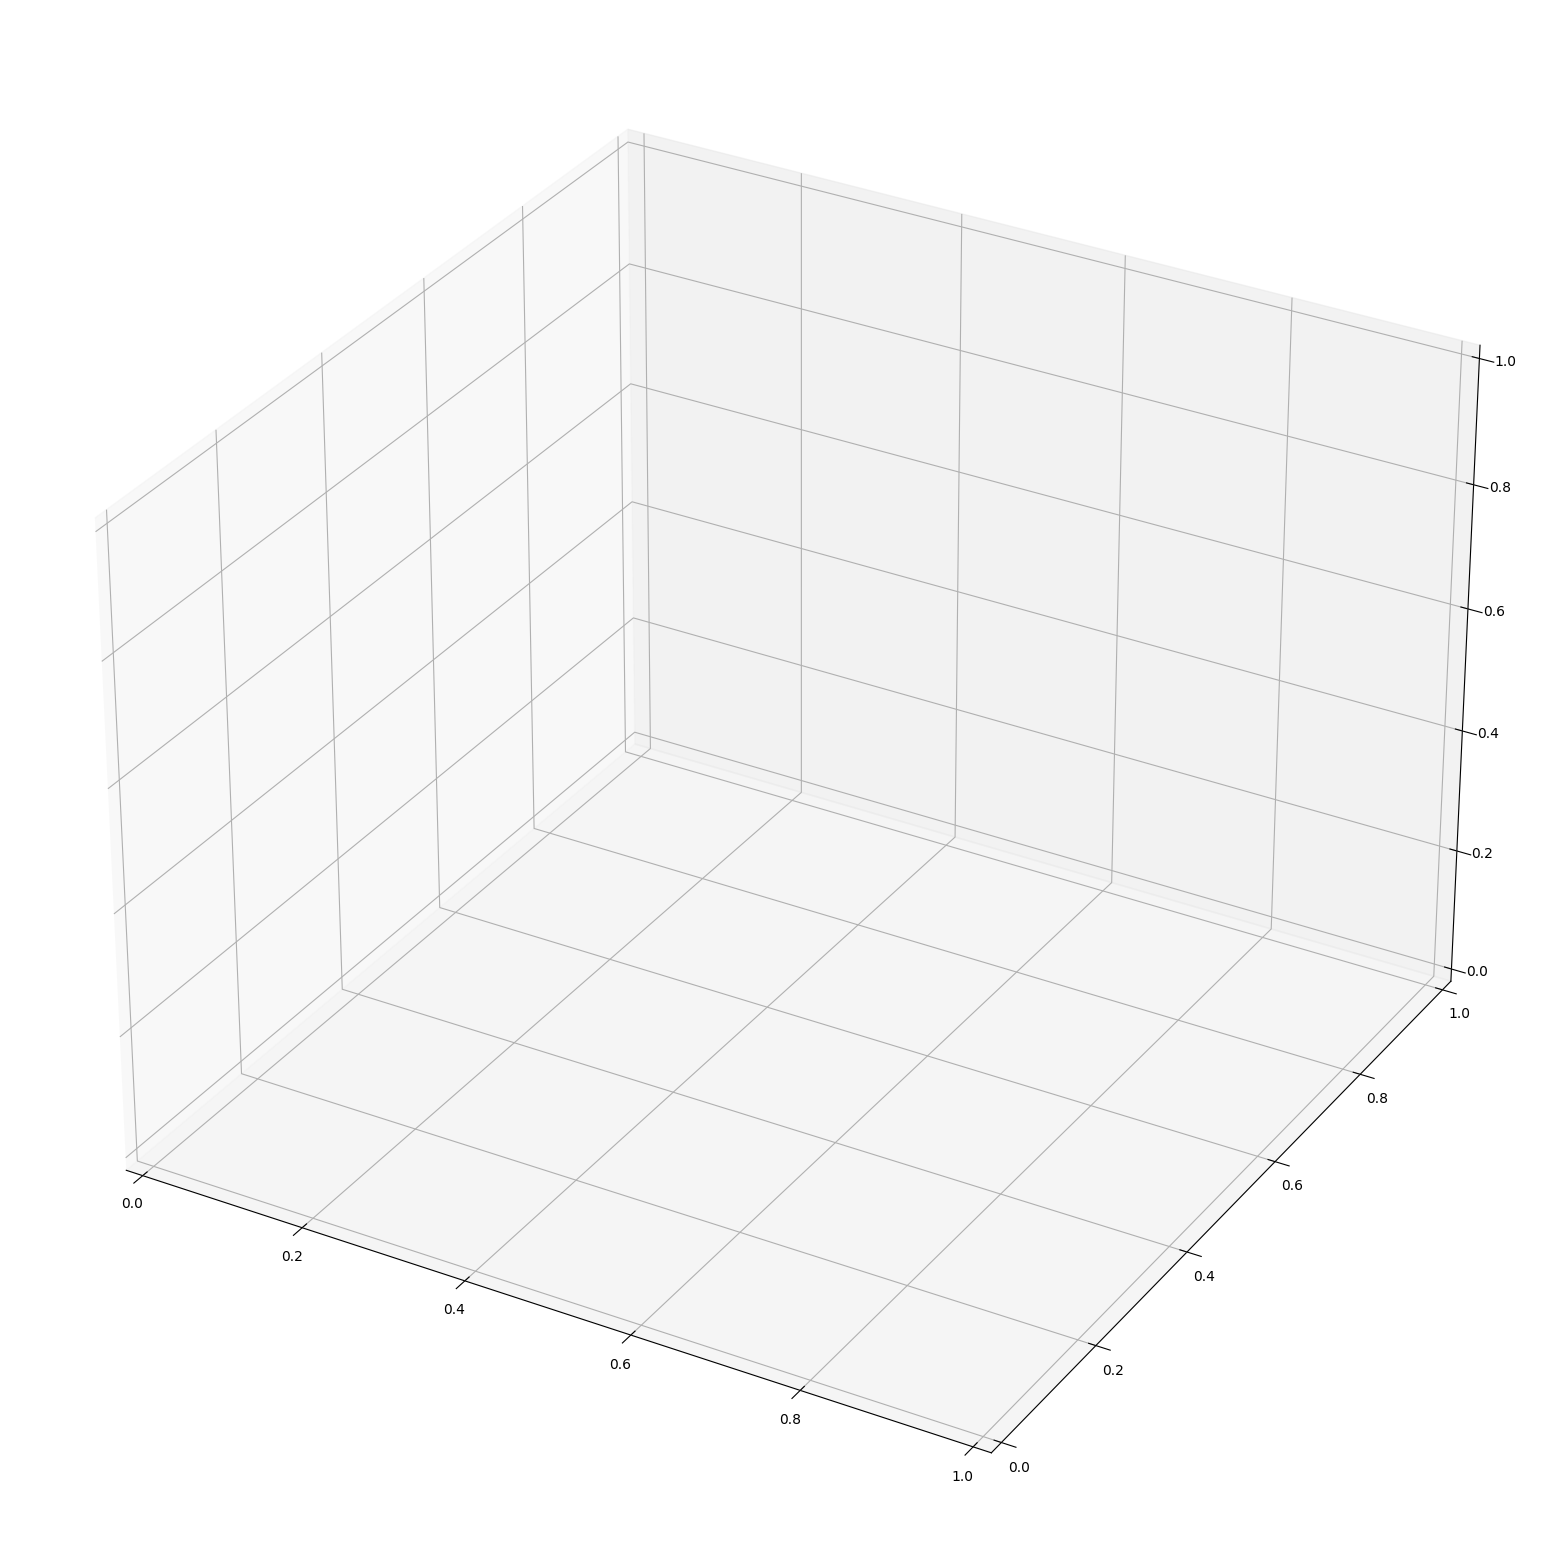

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

In [ ]:
#z(latent space) 3차원 그래프 시각화
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(device) #gpu
encoded_data , _ = model(test_x)
encoded_data = encoded_data.to('cpu')

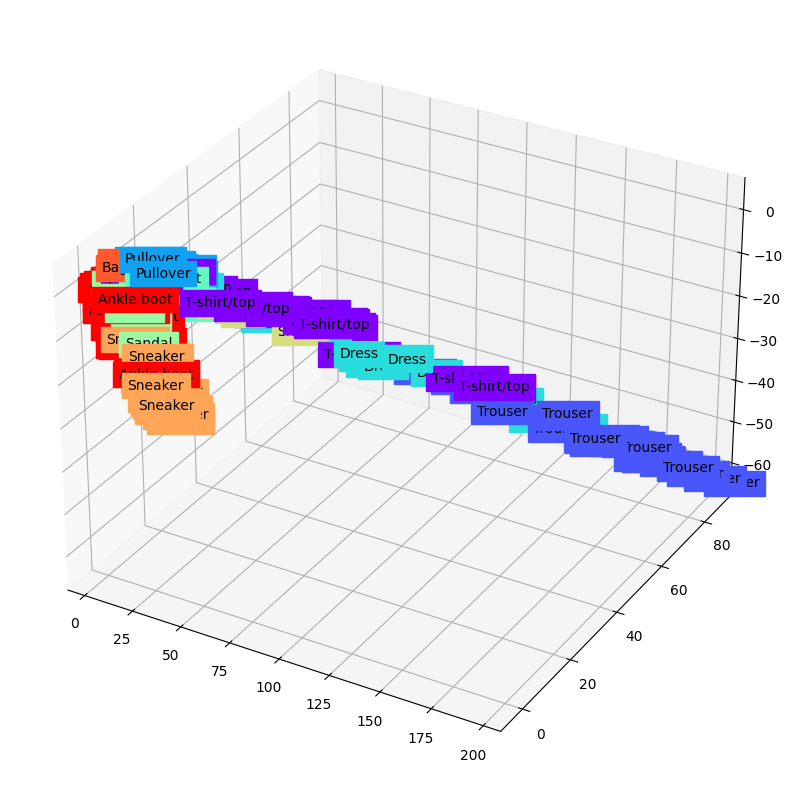

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.targets[:200].numpy()

for x,y,z,s in zip(X,Y,Z,labels):
  name = CLASSES[s]
  color = cm.rainbow(int(255*s/9))
  ax.text(x,y,z,name,backgroundcolor=color)

plot_data = ax.scatter(X,Y,Z,color='red')

ax.set_xlim(X.min(),X.max())
ax.set_xlim(Y.min(),Z.max())
ax.set_xlim(X.min(),X.max())

plt.show()